/home/esorenson/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


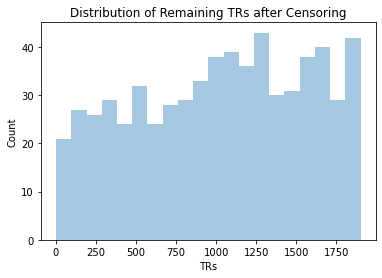

Dataset contains 419 subjects after removing high noise subjects.


In [1]:
from thalpy.analysis import fc, pc, masks, denoise
from thalpy.analysis import plotting as kaiplot
import thalpy.base as base

import numpy as np
import nilearn
import pandas as pd
from nilearn.decoding import Decoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting

DATASET_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/HCP_D/"
DIR_TREE = base.DirectoryTree(DATASET_DIR)
INTERVIEW_AGE = "interview_age"

# cortical_masker = masks.get_roi_mask(masks.SCHAEFER_PATH)
# def calc_fc(n_masker, m_masker):
#     fc_data = fc.FcData(
#         DATASET_DIR,
#         n_masker,
#         m_masker,
#         "cortical",
#         task="rest",
#         cores=16,
#     )
#     fc_data.calc_fc()

#     return fc_data
# calc_fc(cortical_masker, cortical_masker)


fc
kaiplot.plot_TR_distribution(fc_data)

fc_data.fc_subjects = [
    subject
    for subject in fc_data.fc_subjects
    if subject is not None and subject.TR > 800
]

demographics_df = (
    pd.read_csv(DIR_TREE.bids_dir + "participants.tsv", sep="\t")
    .sort_values("participant_id")
    .set_index("participant_id")
)
demographics_df[INTERVIEW_AGE] = demographics_df[INTERVIEW_AGE].apply(
    lambda x: float(str(x)[:-1] + "." + str(x)[-1])
)

num_sub = len(fc_data.fc_subjects)
fc_array = np.zeros((num_sub, fc_data.n * fc_data.m))
age_array = np.zeros(num_sub)
for i, subject in enumerate(fc_data.fc_subjects):
    if subject is None:
        continue
    age = demographics_df.loc[int(subject.name), INTERVIEW_AGE]
    setattr(subject, "age", age)
    fc_array[i, :] = subject.seed_to_voxel_correlations.flatten()
    age_array[i] = age

print(f"Dataset contains {num_sub} subjects after removing high noise subjects.")


/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


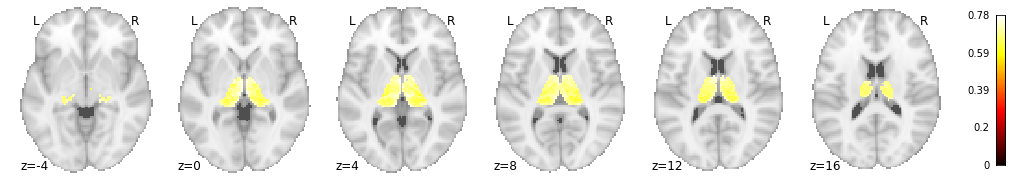

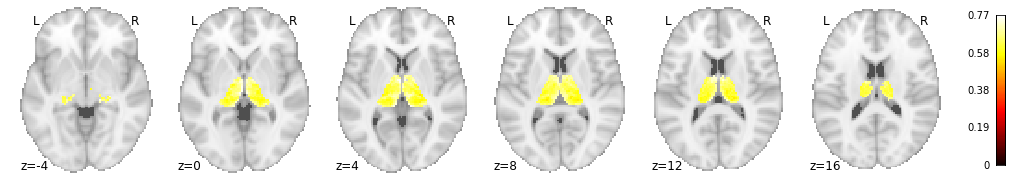

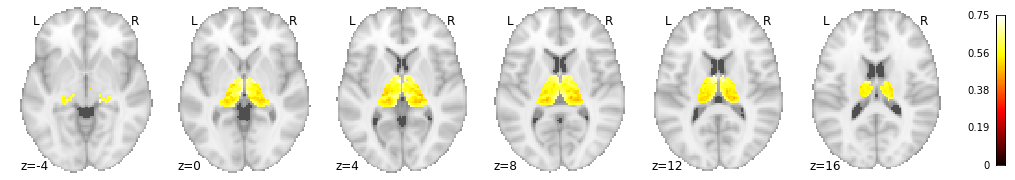

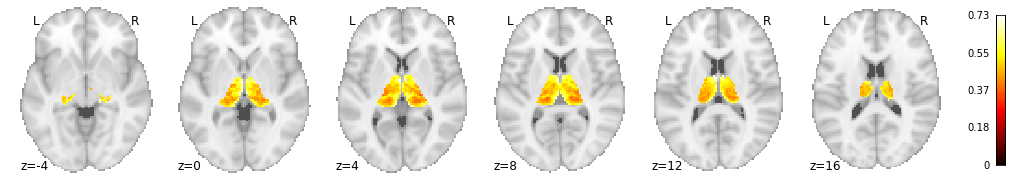

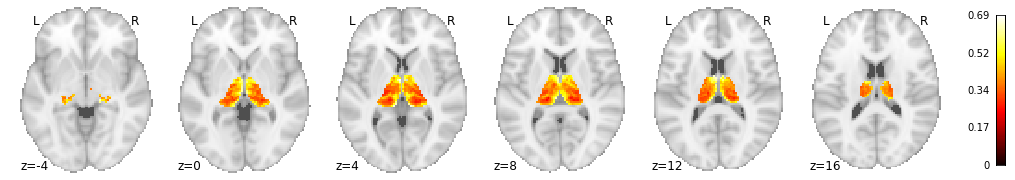

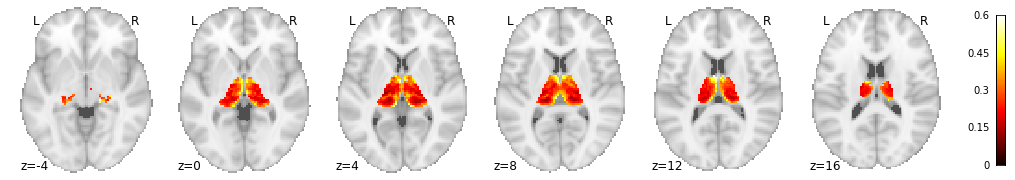

In [8]:
from thalpy.analysis import pc
from thalpy.analysis import plotting as kaiplot
# calculate pc
pc_matrix = pc.pc_dataset(np.swapaxes(fc_data.data, 0, 1), masks.SCHAEFER_7CI, thresholds=[70, 75, 80, 85, 90, 95], output_path=DIR_TREE.analysis_dir + 'pc_thal_schaefer')

for threshold in np.arange(pc_matrix.shape[1]):
    averaged_pc = np.nanmean(pc_matrix[:, threshold, :], axis=-1)
    fc_data.m_masker.fit()
    img = fc_data.m_masker.inverse_transform(averaged_pc)
    kaiplot.plot_thal(img, vmin=np.min(averaged_pc))

(419, 890800)
Explained variance:
[0.13624212 0.02914107 0.02224677 0.01694767 0.01131142 0.00963355
 0.00845212 0.00754072 0.00656527 0.00641791 0.0060402  0.00580143
 0.00569148 0.00559283 0.00529961 0.00516481 0.00491679 0.00479921
 0.00467048 0.00446599 0.00439382 0.00431847 0.00420654 0.00413201
 0.00401536 0.00395278 0.0038717  0.00380793 0.00374592 0.00369291
 0.00363306 0.00357956 0.00352623 0.00351176 0.00344271 0.00342608
 0.00334865 0.00333508 0.00327815 0.00324664 0.00322952 0.0031798
 0.00313906 0.0030882  0.00305944 0.0030256  0.00301064 0.00298328
 0.00294702 0.00293178 0.00290754 0.00287618 0.00287098 0.00285082
 0.00282906 0.00281159 0.0028012  0.00278476 0.0027693  0.00275033
 0.00271016 0.00269219 0.00267778 0.00264224 0.00262609 0.00261427
 0.00260185 0.00258176 0.00257608 0.00255706 0.0025423  0.00252385
 0.00251915 0.00250266 0.00249081 0.00247984 0.00246961 0.0024541
 0.00245163 0.00243845 0.00242595 0.0024151  0.00240239 0.0023959
 0.00238441 0.00237541 0.002352

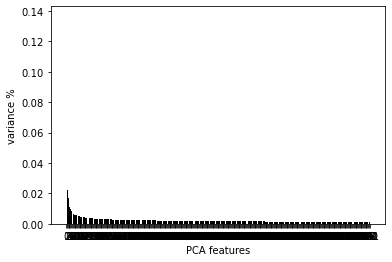

(419, 362)


In [7]:
from thalpy.analysis import feature_extraction
# feature extraction with pca
print(fc_array.shape)
fc_array_comps = feature_extraction.compute_PCA(fc_array)
print(fc_array_comps.shape)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    fc_array_comps, age_array, test_size=0.2, random_state=0
)
print(f"Training data (80% of dataset) contains {len(x_train)} subjects")
print(f"Testing data (20% of dataset) contains {len(x_test)} subjects")

svr = svm.SVR(kernel="linear")
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(svr, x_train, y_train, cv=cv)
print(scores)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)
svr.fit(x_train, y_train)

Training data (80% of dataset) contains 335 subjects
Testing data (20% of dataset) contains 84 subjects
[-19.09473254 -11.06727712  -1.63008078 -12.94667044 -14.33029312]
-11.81 accuracy with a standard deviation of 5.74


SVR(kernel='linear')

0.2420787937325839


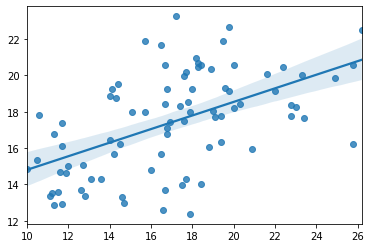

In [12]:
from sklearn.metrics import r2_score
from sklearn import linear_model

x_train, x_test, y_train, y_test = train_test_split(
    fc_array, age_array, test_size=0.2, random_state=0
)

lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)
predicted_ages = lasso_model.predict(x_test)
r_squared = r2_score(y_test, predicted_ages)
print(r_squared)
sns.regplot(x=y_test, y=predicted_ages)



In [5]:
nodes_coef = np.reshape(svr.coef_, (fc_data.n, fc_data.m))
plotting.plot_matrix(nodes_coef, title='Contribution to SVR')

thal_avg_coef = np.mean(nodes_coef, axis=0)
schaef_avg_coef = np.mean(nodes_coef, axis=1)

fc_data.m_masker.fit()
img = fc_data.m_masker.inverse_transform(thal_avg_coef)
kaiplot.plot_thal(img)

# fc_data.n_masker.fit()
# schaef_img = fc_data.n_masker.inverse_transform(schaef_avg_coef)
# plotting.plot_stat_map(schaef_img)


ValueError: cannot reshape array of size 362 into shape (400,2227)

R^2 = 0.27505295149665665


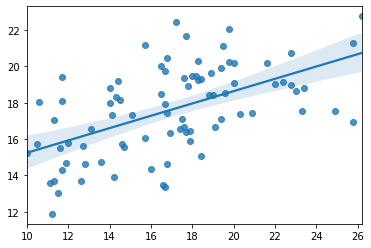

In [49]:
from sklearn.metrics import r2_score
predicted_ages = svr.predict(x_test)
sns.regplot(x=y_test, y=predicted_ages)
r2 = r2_score(y_test, predicted_ages)
print(f'R^2 = {r2}')
plt.show()

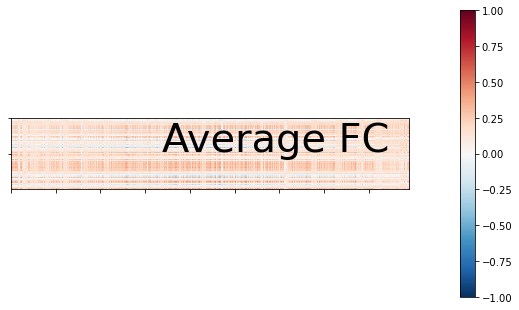

In [45]:


averaged_fc = np.mean(fc_data.data, axis=-1)
plotting.plot_matrix(averaged_fc, vmax=1, vmin=-1, title='Average FC')

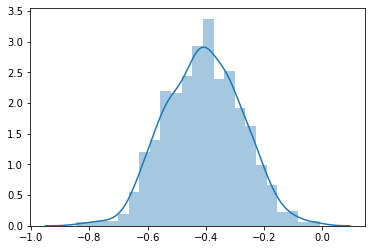

In [53]:
k = 1000
permutations = np.zeros(k)
for i in np.arange(k):
    permutations[i] = r2_score(np.random.permutation(y_test), np.random.permutation(predicted_ages))
sns.distplot(permutations)
    